# Identification of patterns and prediction of irregular parking

## Introduction

### Challenge Provider: Project Urban Co-creation Data (UCD Lab)
The Project UCD Lab is co-financed by CEF Telecom, the EU instrument to facilitate
cross-border interaction between public administrations, businesses and citizens, and the
project beneficiaries are: Universidade Nova de Lisboa, Município de Lisboa, Agência para a
Modernização Administrativa, I.P., NEC Portugal - Telecomunicações e Sistemas, S.A, and
Barcelona Supercomputing Center - Centro Nacional de Supercomputación..
The UCD Lab project aims to support decision-making at the municipality level to provide
citizens with high-quality services in the areas of micro-mobility, waste management,
parking, pollution and emergency. By building analytical capabilities and services in these
areas, municipalities will be able to better respond to day to day challenges.
### Context
As the population that lives, works and visits cities increases, parking capability is under
pressure, namely due to unattractive or insufficient public transportation, inadequate
drivers’ education and insufficient regulation. On the one hand, predicting irregular
parking can aid the municipality services to optimise parking inspection and dissuade
possible drivers’ irregular behaviour. On the other hand, it leads to fewer congestions and
CO2 emissions as the many times irregular parking reduces the traffic flow.
### Goals
Improve parking surveillance to dissuade irregular parking.

### Outcome
An explainable predictive model of irregular parking at street level and period of the
day.

## Initialize

In [ ]:
# Mount the drive folder
from google.colab import drive # to load data from google drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Load libraries
import os # For files operations
import urllib.request # For download from url
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # ploting the data
import seaborn as sns # ploting the data
import csv # to import data in txt files

In [ ]:
# to use Panda profilling
# See the output to NULL for notebook readibility
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip > NULL
from pandas_profiling import ProfileReport

In [ ]:
# Set up color blind friendly color palette
# The palette with grey:
cbPalette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
# The palette with black:
cbbPalette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# sns.palplot(sns.color_palette(cbPalette))
# sns.palplot(sns.color_palette(cbbPalette))

sns.set_palette(cbPalette)
#sns.set_palette(cbbPalette)

In [ ]:
# Seaborn favourite plot shortcuts
def boxplot(data, x, y, title = ""):
    
    """
    This function generates a seaborn boxplot with my defaults parameters.

    Parameters:
        title (string) title of the plot, default is empty
        data (df) the data frame
        x (panda serie) the x axis
        y (panda serie) the y axis
    """

    f, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(x=x, y=y, data=data, notch=True, showmeans=True,
           meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"black"})
    plt.title(title)
    plt.ioff()

def countplot(data, variable, title = ""):
    """
    This function contains my favourite parameters for the seaborn coutplot plot
    """

    f, ax = plt.subplots(figsize=(8, 6))
    sns.countplot(data=data, x=variable)
    plt.title(title)
    plt.ioff()

## Dataset

* [Vancouver Portal](https://opendata.vancouver.ca/explore/dataset/public-streets/export/?q=&location=18,49.28242,-123.11627)
    * [Whole Dataset Excel](https://opendata.vancouver.ca/explore/dataset/public-streets/download/?format=xls&timezone=Europe/London&lang=en&use_labels_for_header=true)
    * [GeoJSON File](https://opendata.vancouver.ca/explore/dataset/public-streets/download/?format=geojson&timezone=Europe/London&lang=en)
* [Parking Ticket](https://wdl-data.fra1.digitaloceanspaces.com/urban-analytics/parking-tickets-2017-2019_WDL.csv)

## Possible relevant datasets

* https://www.kaggle.com/new-york-city/nyc-parking-tickets
* https://data.world/datagov-uk/897320fd-9f5c-4436-8753-b97519f5d1d5

## EDA

In [ ]:
# Set up the path for the data and output folders to the challenge and list files
PATH = "/content/drive/MyDrive/Data_science/WDL/Stage2/Irregular_Parking/"
data = PATH + "Data"
os.listdir(data)

['public-streets.csv',
 'public-streets.geojson',
 'public-streets.xls',
 'parking-tickets-2017-2019_WDL.csv',
 'merged_parking.csv']

In [ ]:
output = PATH + "Output"
os.listdir(output)

['public-streets.html',
 'parking-tickets-2017-2019_WDL.html',
 'merged_dataset.html']

In [ ]:
file = data + "/" + "public-streets.csv"
streets = pd.read_csv(file, sep = ';', encoding = 'UTF-8')
streets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17034 entries, 0 to 17033
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Geom       17034 non-null  object
 1   HBLOCK     17034 non-null  object
 2   STREETUSE  17034 non-null  object
dtypes: object(3)
memory usage: 399.4+ KB


In [ ]:
streets.head()

,Geom,HBLOCK,STREETUSE
0,"{""type"": ""LineString"", ""coordinates"": [[-123.1...",CAMBIE BRIDGE,Arterial
1,"{""type"": ""LineString"", ""coordinates"": [[-123.0...",0 N LAKEWOOD DRIVE,Residential
2,"{""type"": ""LineString"", ""coordinates"": [[-123.1...",600 KINGHORNE MEWS,Residential
3,"{""type"": ""LineString"", ""coordinates"": [[-123.0...",3200-3300 FINDLAY ST,Residential
4,"{""type"": ""LineString"", ""coordinates"": [[-123.1...",6100-6200 VINE ST,Residential


In [ ]:
streets.loc[0,"Geom"]

'{"type": "LineString", "coordinates": [[-123.11476875239016, 49.273158123392065], [-123.1148891224127, 49.26955258599314]]}'

In [ ]:
file = data + "/" + "parking-tickets-2017-2019_WDL.csv"
tickets = pd.read_csv(file, sep = ';', encoding = 'UTF-8')
tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318735 entries, 0 to 1318734
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Unnamed: 0      1318735 non-null  int64 
 1   Block           1318735 non-null  int64 
 2   Street          1318735 non-null  object
 3   EntryDate       1318735 non-null  object
 4   Bylaw           1318735 non-null  int64 
 5   Section         1318735 non-null  object
 6   Status          1318735 non-null  object
 7   InfractionText  1318735 non-null  object
 8   Year            1318735 non-null  int64 
 9   HBLOCK          1318735 non-null  object
dtypes: int64(4), object(6)
memory usage: 100.6+ MB


In [ ]:
tickets.head()

,Unnamed: 0,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK
0,0,1400,Kingsway,2017-08-23,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2017,1400 KINGSWAY
1,1,2100,13th Ave E.,2017-08-26,2849,19.1(H),IS,STOP ON EITHER SIDE OF A LANE WHICH ABUTS COMM...,2017,2100 13TH AVE E
2,2,2800,Trinity St.,2017-08-26,2849,17.6(B),VA,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,2017,2800 TRINITY ST
3,3,200,17th Ave W.,2017-08-27,2849,17.5(B),IS,STOP WITHIN 6 METRES OF THE NEAREST EDGE OF TH...,2017,200 17TH AVE W
4,4,1900,4th Ave W.,2017-08-19,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1900 4TH AVE W


In [ ]:
# Read json file
# see https://stackoverflow.com/questions/42753745/how-can-i-parse-geojson-with-python
file = data + "/" + "public-streets.geojson"
public_streets = pd.read_json(file)

In [ ]:
public_streets.head()

,type,features
0,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Line..."
1,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Line..."
2,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Line..."
3,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Line..."
4,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Line..."


In [ ]:
public_streets.loc[0,"features"]

{'geometry': {'coordinates': [[-123.11476875239016, 49.273158123392065],
   [-123.1148891224127, 49.26955258599314]],
  'type': 'LineString'},
 'properties': {'hblock': 'CAMBIE BRIDGE', 'streetuse': 'Arterial'},
 'type': 'Feature'}

In [ ]:
# Read Merged File
file = data + "/" + "merged_parking.csv"
merged = pd.read_csv(file)
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35477 entries, 0 to 35476
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      35477 non-null  int64  
 1   Block           35477 non-null  int64  
 2   Street          35477 non-null  object 
 3   EntryDate       35477 non-null  object 
 4   Bylaw           35477 non-null  int64  
 5   Section         35477 non-null  object 
 6   Status          35477 non-null  object 
 7   InfractionText  35477 non-null  object 
 8   Year            35477 non-null  float64
 9   HBLOCK          35477 non-null  object 
 10  STREETUSE       35477 non-null  object 
 11  coord_1         35477 non-null  object 
 12  coord_2         35477 non-null  object 
dtypes: float64(1), int64(3), object(9)
memory usage: 3.5+ MB


In [ ]:
# Automated EDA
file = output + "/" + "public-streets.html"
report = ProfileReport(streets)
report.to_file(output_file=file)

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
file = output + "/" + "parking-tickets-2017-2019_WDL.html"
report = ProfileReport(tickets)
report.to_file(output_file=file)

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
file = output + "/" + "merged_dataset.html"
report = ProfileReport(merged)
report.to_file(output_file=file)

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

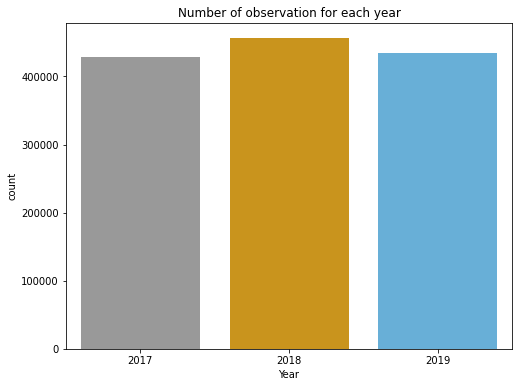

In [ ]:
# Test a simple plot of the number of years
countplot(tickets, 
          'Year',
          "Number of observation for each year")

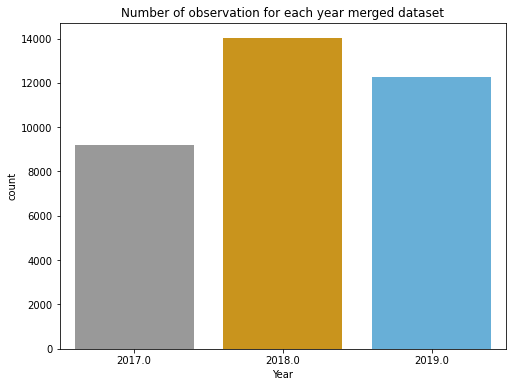

In [ ]:
countplot(merged, 
          'Year',
          "Number of observation for each year merged dataset")

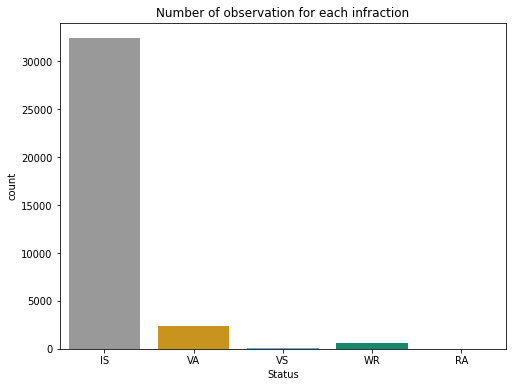

In [ ]:
countplot(merged, 
          'Status',
          "Number of observation for each infraction")

## Key Take Away from EDA

* the dataset contains only infractions. Some street might be larger or busier than other which could biase the dataset.
* There is no missing values
* The majority of illegal parking result in fine (IS)

## Model

### Baseline Model Random Forest Classification

In [ ]:
selected_variables = ["Street", "EntryDate", "coord_1", "coord_2", "STREETUSE", "Status"]
df = merged[selected_variables].copy()
df.head()

,Street,EntryDate,coord_1,coord_2,STREETUSE,Status
0,Kingsway,2017-08-23,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",Arterial,IS
1,KINGSWAY,2018-07-25,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",Arterial,IS
2,KINGSWAY,2019-07-03,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",Arterial,VA
3,KINGSWAY,2018-01-08,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",Arterial,IS
4,KINGSWAY,2018-01-04,"[-123.07609868345955, 49.250113144142205]","[-123.07335078330377, 49.248972158836736]",Arterial,IS


In [ ]:
# Encoding of the categorical variables
# https://www.hackdeploy.com/python-one-hot-encoding-with-scikit-learn/
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

from sklearn.preprocessing import LabelEncoder
le_street = LabelEncoder()
le_streetuse = LabelEncoder()
le_entrydate = LabelEncoder()
le_coord_1 = LabelEncoder()
le_coord_2 = LabelEncoder()
le_status = LabelEncoder()

df['Street'] = le_street.fit_transform(df.Street)
df['STREETUSE'] = le_streetuse.fit_transform(df.STREETUSE)
df['EntryDate'] = le_entrydate.fit_transform(df.EntryDate)
df['coord_1'] = le_coord_1.fit_transform(df.coord_1)
df['coord_2'] = le_coord_2.fit_transform(df.coord_2)
df['Status'] = le_status.fit_transform(df.Status)

df.head()

,Street,EntryDate,coord_1,coord_2,STREETUSE,Status
0,246,127,903,888,0,0
1,238,305,903,888,0,0
2,238,542,903,888,0,2
3,238,207,903,888,0,0
4,238,203,903,888,0,0


In [ ]:
# Separate into variables and target variable
X=df.iloc[:,0:4].values
y=df.iloc[:,5].values

In [ ]:
# Split the dataset in train and test
# https://realpython.com/train-test-split-python-data/
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

In [ ]:
#fitting the random forest regression to the dataset
# https://iq.opengenus.org/random-forests-using-scikit-learn/
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X_train, y_train = make_classification(n_samples=1000, n_features=4, n_informative=2, n_redundant=0, random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# Evaluate the model
# https://scikit-learn.org/stable/modules/model_evaluation.html
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.00022547914317925591

The first test model performs poorly.
The data is unbalanced with the number if IS case being largely dominant. I might have to use package such as SMOTE to remedy this before fittin the classification model. 
Also some category such as RA are very rare and might need to be removed. 
